<a href="https://colab.research.google.com/github/GustavoGran/ecommerce_recomender/blob/main/ptc3467_classifica%C3%A7%C3%A3o_rede_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Exploratória de Dados - Dados de E-commerce Brasileiro**

##**Importando Bibliotecas**

In [ ]:
import pandas as pd
import numpy  as np
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/Shared drives/Projeto Ciência de Dados/dataset/treated_olist_ecommerce" 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shared drives/Projeto Ciência de Dados/dataset/treated_olist_ecommerce


In [ ]:
%ls

classification_2020_11_25_10/  ConfusionMatrix.png  olist_consolidated.csv


##**Leitura do dataset**

In [ ]:
df = pd.read_csv('olist_consolidated.csv').drop(['Unnamed: 0'],axis=1);
df.shape

(109535, 12)

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
estimated_delivery_days,109535.0,24.457854,8.838442,3.000000,19.000000,24.000000,29.000000,156.000000
price_log,109535.0,4.317444,0.922087,-0.150823,3.686627,4.316287,4.904608,8.815075
freight_value_log,109535.0,2.810926,0.698249,-4.605170,2.571849,2.791165,3.053529,6.015401
product_name_lenght,109535.0,48.799598,10.011535,5.000000,42.000000,52.000000,57.000000,76.000000
product_description_lenght,109535.0,786.972630,652.298760,4.000000,347.000000,601.000000,985.000000,3992.000000
product_photos_qty,109535.0,2.203177,1.714753,1.000000,1.000000,1.000000,3.000000,20.000000
product_weight_g,109535.0,2096.390241,3740.711084,0.000000,300.000000,700.000000,1800.000000,40425.000000
product_length_cm,109535.0,30.216360,16.160274,7.000000,18.000000,25.000000,38.000000,105.000000
product_height_cm,109535.0,16.611960,13.447127,2.000000,8.000000,13.000000,20.000000,105.000000
product_width_cm,109535.0,23.042050,11.681227,6.000000,15.000000,20.000000,30.000000,118.000000


In [ ]:
df.head(3).transpose()

,0,1,2
estimated_delivery_days,16.000000,20.000000,27.000000
price_log,3.401197,4.776684,5.074611
freight_value_log,2.166765,3.125444,2.956472
product_name_lenght,40.000000,29.000000,46.000000
product_description_lenght,268.000000,178.000000,232.000000
product_photos_qty,4.000000,1.000000,1.000000
product_weight_g,500.000000,400.000000,420.000000
product_length_cm,19.000000,19.000000,24.000000
product_height_cm,8.000000,13.000000,19.000000
product_width_cm,13.000000,19.000000,21.000000


In [ ]:
df.isna().sum()

estimated_delivery_days       0
price_log                     0
freight_value_log             0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_length_cm             0
product_height_cm             0
product_width_cm              0
review_score                  0
freight_distance              0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df_train = df.sample(frac=0.8,random_state=0)
df_test = df.drop(df_train.index)

In [ ]:
print('shape df_train : ', df_train.shape)
print('shape df_test : ', df_test.shape)

shape df_train :  (87628, 12)
shape df_test :  (21907, 12)


##**Separando a variável prevista**

In [ ]:
train_labels = df_train['review_score'];
test_labels = df_test['review_score'];

df_train.drop('review_score', axis=1, inplace=True);
df_test.drop('review_score', axis=1, inplace=True);

train_labels.head()

95972     5
101699    5
38305     5
71904     5
45309     1
Name: review_score, dtype: int64

In [ ]:
train_labels = train_labels.apply(lambda x: x-1)

train_labels.head()

95972     4
101699    4
38305     4
71904     4
45309     0
Name: review_score, dtype: int64

In [ ]:
test_labels = test_labels.apply(lambda x: x-1)

test_labels.head()

2     4
10    0
13    4
20    1
21    4
Name: review_score, dtype: int64

In [ ]:
train_stats = df_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
estimated_delivery_days,87628.0,24.465217,8.851604,3.000000,19.000000,24.000000,29.000000,156.000000
price_log,87628.0,4.319458,0.921765,-0.150823,3.686627,4.317621,4.905275,8.815075
freight_value_log,87628.0,2.812879,0.696980,-4.605170,2.571849,2.791778,3.054473,6.015401
product_name_lenght,87628.0,48.787168,10.006541,5.000000,42.000000,52.000000,57.000000,72.000000
product_description_lenght,87628.0,785.661478,650.526531,4.000000,347.000000,600.000000,984.000000,3992.000000
product_photos_qty,87628.0,2.204489,1.717175,1.000000,1.000000,1.000000,3.000000,20.000000
product_weight_g,87628.0,2102.137833,3749.060739,0.000000,300.000000,700.000000,1800.000000,40425.000000
product_length_cm,87628.0,30.225122,16.181969,7.000000,18.000000,25.000000,38.000000,105.000000
product_height_cm,87628.0,16.620407,13.480956,2.000000,8.000000,13.000000,20.000000,105.000000
product_width_cm,87628.0,23.058805,11.680778,6.000000,15.000000,20.000000,30.000000,118.000000


##**Normalização dos dados**

In [ ]:
def normalize(dataset):
  return (dataset - train_stats['mean']) / train_stats['std']

df_train_normed = normalize(df_train)
df_test_normed = normalize(df_test)

###**Construção do modelo**

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(11, input_shape=[len(df_train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(16, activation='relu'),
    layers.Dense(5, activation='softmax')
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['mae', 'mse', 'accuracy'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 11)                132       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                768       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 85        
Total params: 3,593
Trainable params: 3,593
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = df_train_normed[:10]
example_result = model.predict(example_batch)
example_result

array([[0.20070137, 0.18733864, 0.16077833, 0.24631676, 0.2048649 ],
       [0.29653504, 0.20970829, 0.1034333 , 0.11327621, 0.27704716],
       [0.28053358, 0.16078465, 0.15965769, 0.12397453, 0.2750495 ],
       [0.07698423, 0.09801316, 0.31192452, 0.3553724 , 0.1577057 ],
       [0.13559014, 0.16432844, 0.2630001 , 0.2636289 , 0.17345251],
       [0.20851336, 0.18612766, 0.10183641, 0.30150333, 0.20201927],
       [0.15995906, 0.13295603, 0.27234405, 0.28090873, 0.1538321 ],
       [0.19934775, 0.1983635 , 0.10304853, 0.1119412 , 0.38729903],
       [0.19976236, 0.18069068, 0.24685103, 0.17799023, 0.19470572],
       [0.15112549, 0.13582008, 0.2940765 , 0.24281292, 0.17616506]],
      dtype=float32)

##**Treinando o modelo**

In [ ]:
# Mostra o progresso do treinamento imprimindo um único ponto para cada epoch completada
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  df_train_normed, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
95,1.151462,2.917787,10.121368,0.581253,1.225830,2.903822,10.067553,0.568356,95
96,1.151228,2.917789,10.121342,0.581681,1.224826,2.903822,10.066813,0.568413,96
97,1.151223,2.917785,10.121440,0.581068,1.229057,2.903822,10.069901,0.567443,97
98,1.150536,2.917793,10.121432,0.582080,1.225000,2.903822,10.069649,0.568926,98
99,1.150293,2.917789,10.121459,0.581881,1.226261,2.903822,10.067939,0.568527,99


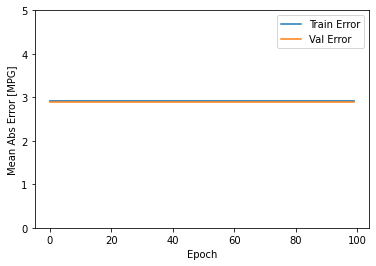

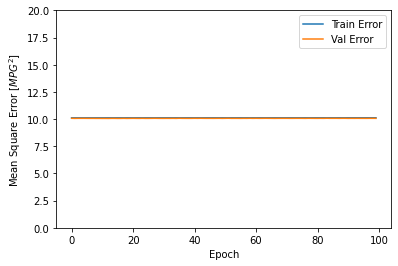

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
# model = build_model()

# # O paramêtro patience é o quantidade de epochs para checar as melhoras
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
#                     validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

# plot_history(history)

In [ ]:
loss, mae, mse, accuracy = model.evaluate(df_test_normed, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Review Score".format(mae))

685/685 - 1s - loss: 1.2225 - mae: 2.9118 - mse: 10.0986 - accuracy: 0.5696
Testing set Mean Abs Error:  2.91 Review Score


In [ ]:
## Genetare Predictions ##

# Predictions for default model:
predictions = model.predict(df_test_normed)
# Classifying based on predictions:
c = np.argmax(predictions, axis=1)

print(set(c))

{0, 1, 2, 3, 4}


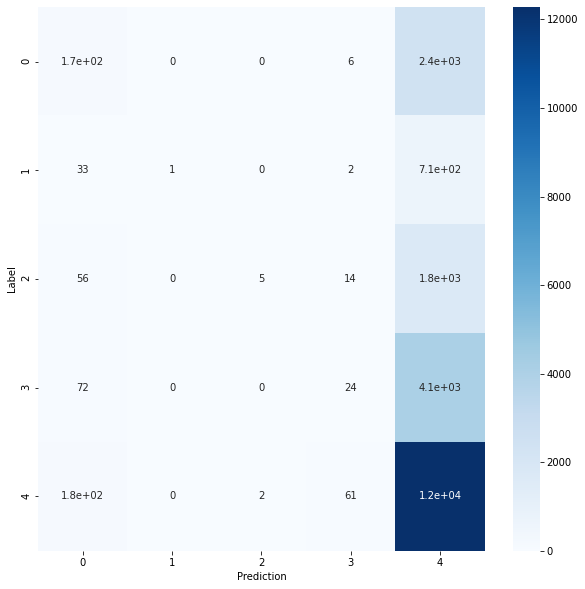

In [ ]:
## Evaluate Classification ##


# Turn label into numpy column vector
l = np.array(test_labels).T

# Create pandas dataframe to store all results and label:
df = pd.DataFrame({'Prediction Classes': c, 'Test Label': l})

# Create confusion matrix 1:
confusion_matrix = pd.crosstab(df['Test Label'], df['Prediction Classes'], rownames=['Label'], colnames=['Prediction']) #, normalize='index'
# Displaying confusion matrix 1:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.savefig("ConfusionMatrix.png") #save figure
plt.show()

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Review Score]")
_ = plt.ylabel("Count")

NameError: ignored

In [ ]:
#%cd "/content/drive/Shared drives/Projeto Ciência de Dados/models/classification_2020_11_25_10" 
model.save('classification_2020_11_25_10')

INFO:tensorflow:Assets written to: classification_2020_11_25_10/assets


In [ ]:
%ls
%cd "/content/drive/Shared drives/Projeto Ciência de Dados/models/"
%ls
model.save('classification_2020_11_25_10')

classification_2020_11_25_10/  deep_learning_2020_11_25_10/
/content/drive/Shared drives/Projeto Ciência de Dados/models
classification_2020_11_25_10/  deep_learning_2020_11_25_10/
INFO:tensorflow:Assets written to: classification_2020_11_25_10/assets
